In [7]:
import pandas as pd
import numpy as np

# Base cleaned data
train = pd.read_csv("train.csv")
train = train.drop(columns=['id', 'Episode_Title'])
train = train.dropna()

# Categorical dtype setup
categorical_cols = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
for col in categorical_cols:
    train[col] = train[col].astype('category')

### Add Engineered Features (Phase 1)

In [11]:
# 1. Popularity Interaction
train['Popularity_Interaction'] = train['Host_Popularity_percentage'] * train['Guest_Popularity_percentage']

# 2. Ad Density
train['Ad_Density'] = train['Number_of_Ads'] / train['Episode_Length_minutes']

# 3. Has Guest (binary flag)
train['Has_Guest'] = (train['Guest_Popularity_percentage'] > 0).astype(int)

# 4. Is Weekend (binary)
train['Is_Weekend'] = train['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)

# 5. Is Evening
train['Is_Evening'] = (train['Publication_Time'] == 'Evening').astype(int)

# 6. Sentiment Score
sentiment_map = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
train['Sentiment_Score'] = train['Episode_Sentiment'].map(sentiment_map)

# 7. Length Bin
bins = [0, 10, 30, np.inf]
labels = ['Short', 'Medium', 'Long']
train['Length_Bin'] = pd.cut(train['Episode_Length_minutes'], bins=bins, labels=labels)

# Add new categorical column to list
categorical_cols.append('Length_Bin')

In [13]:
train[['Popularity_Interaction', 'Ad_Density', 'Has_Guest', 'Is_Weekend', 'Is_Evening', 'Sentiment_Score', 'Length_Bin']].head()

,Popularity_Interaction,Ad_Density,Has_Guest,Is_Weekend,Is_Evening,Sentiment_Score,Length_Bin
1,5084.8525,0.016694,1,1,0,-1,Long
2,627.6309,0.000000,1,0,1,-1,Long
3,4503.2140,0.029775,1,0,0,1,Long
4,4698.5076,0.027147,1,0,0,0,Long
6,1397.6964,0.000000,1,1,0,0,Long


## LightGBM Training with Engineered Features

In [16]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

### Data Setup

In [19]:
# Load and clean
train = pd.read_csv("train.csv")
train = train.drop(columns=['id', 'Episode_Title'])
train = train.dropna()

# Categorical columns
categorical_cols = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

# Add engineered features
train['Popularity_Interaction'] = train['Host_Popularity_percentage'] * train['Guest_Popularity_percentage']
train['Ad_Density'] = train['Number_of_Ads'] / train['Episode_Length_minutes']
train['Has_Guest'] = (train['Guest_Popularity_percentage'] > 0).astype(int)
train['Is_Weekend'] = train['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)
train['Is_Evening'] = (train['Publication_Time'] == 'Evening').astype(int)
train['Sentiment_Score'] = train['Episode_Sentiment'].map({'Negative': -1, 'Neutral': 0, 'Positive': 1})
train['Length_Bin'] = pd.cut(train['Episode_Length_minutes'], bins=[0, 10, 30, np.inf], labels=['Short', 'Medium', 'Long'])

# Add to categorical list
categorical_cols += ['Length_Bin']
for col in categorical_cols:
    train[col] = train[col].astype('category')

# Define features and target
X = train.drop(columns=['Listening_Time_minutes'])
y = train['Listening_Time_minutes']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train, y_train, categorical_feature=categorical_cols)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 431238, number of used features: 15
[LightGBM] [Info] Start training from score 45.829445


LGBMRegressor(learning_rate=0.05, n_estimators=500, n_jobs=-1, random_state=42)

### Evaluate Performance

In [24]:
y_pred = lgb_model.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"LightGBM with Engineered Features")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

LightGBM with Engineered Features
RMSE: 10.39
MAE: 8.00
R²: 0.8537


C:\Users\james\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Check Residuals

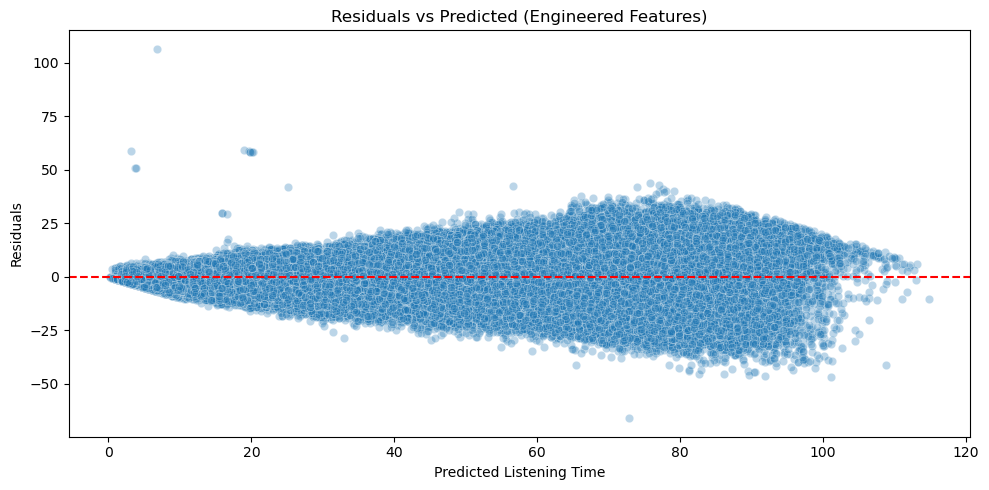

In [27]:
residuals = y_val - y_pred
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Listening Time')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (Engineered Features)')
plt.tight_layout()
plt.show()

### Feature Importance

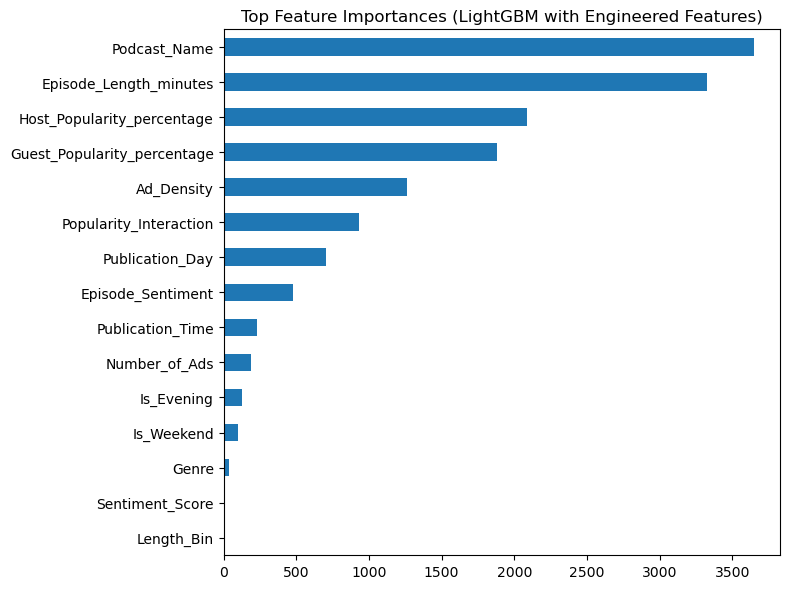

In [30]:
importances = pd.Series(lgb_model.feature_importances_, index=X.columns)
top_importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 6))
top_importances.plot(kind='barh')
plt.title('Top Feature Importances (LightGBM with Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# LightGBM with Log-Transformed Target + Engineered Features

In [33]:
train = pd.read_csv("train.csv")
train = train.drop(columns=['id', 'Episode_Title'])
train = train.dropna()

# Categorical setup
categorical_cols = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

# Engineered features (same as last time)
train['Popularity_Interaction'] = train['Host_Popularity_percentage'] * train['Guest_Popularity_percentage']
train['Ad_Density'] = train['Number_of_Ads'] / train['Episode_Length_minutes']
train['Has_Guest'] = (train['Guest_Popularity_percentage'] > 0).astype(int)
train['Is_Weekend'] = train['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)
train['Is_Evening'] = (train['Publication_Time'] == 'Evening').astype(int)
train['Sentiment_Score'] = train['Episode_Sentiment'].map({'Negative': -1, 'Neutral': 0, 'Positive': 1})
train['Length_Bin'] = pd.cut(train['Episode_Length_minutes'], bins=[0, 10, 30, np.inf], labels=['Short', 'Medium', 'Long'])

categorical_cols += ['Length_Bin']
for col in categorical_cols:
    train[col] = train[col].astype('category')

# Log-transform the target
train['Listening_Log'] = np.log1p(train['Listening_Time_minutes'])

# Define X and transformed y
X = train.drop(columns=['Listening_Time_minutes', 'Listening_Log'])
y_log = train['Listening_Log']


In [35]:
X_train, X_val, y_train_log, y_val_log = train_test_split(X, y_log, test_size=0.2, random_state=42)


In [37]:
lgb_model_log = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

lgb_model_log.fit(X_train, y_train_log, categorical_feature=categorical_cols)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 431238, number of used features: 15
[LightGBM] [Info] Start training from score 3.591692


LGBMRegressor(learning_rate=0.05, n_estimators=500, n_jobs=-1, random_state=42)

In [39]:
y_pred_log = lgb_model_log.predict(X_val)
y_pred = np.expm1(y_pred_log)  # Back-transform predictions
y_val_true = np.expm1(y_val_log)


In [41]:
rmse = mean_squared_error(y_val_true, y_pred, squared=False)
mae = mean_absolute_error(y_val_true, y_pred)
r2 = r2_score(y_val_true, y_pred)

print("LightGBM (Log Target + Engineered Features)")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")


LightGBM (Log Target + Engineered Features)
RMSE: 10.53
MAE: 8.11
R²: 0.8498


C:\Users\james\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


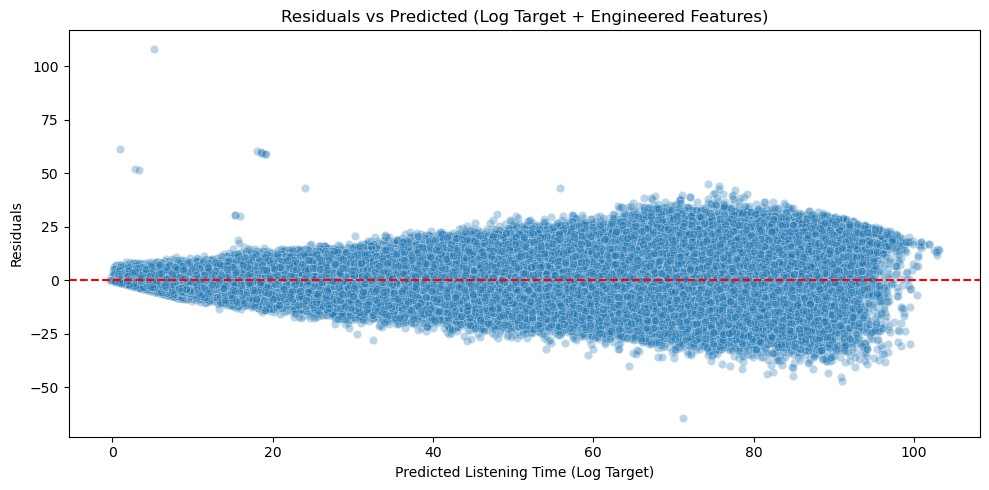

In [43]:
residuals_log = y_val_true - y_pred

plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred, y=residuals_log, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Listening Time (Log Target)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (Log Target + Engineered Features)')
plt.tight_layout()
plt.show()


##  Model Comparison: Engineered Features vs. Log-Transformed Target

###  Model 1: LightGBM with Engineered Features

In this version, we trained LightGBM on the original (non-transformed) listening time target while incorporating a set of engineered features:

- `Popularity_Interaction` = Host × Guest Popularity
- `Ad_Density` = Number of Ads / Episode Length
- `Has_Guest` = 1 if Guest Popularity > 0
- `Is_Weekend` and `Is_Evening` = Temporal binary flags
- `Sentiment_Score` = Numerical mapping of sentiment
- `Length_Bin` = Binned episode length (short, medium, long)

**Performance:**

| Metric | Value |
|--------|-------|
| RMSE   | **10.39** |
| MAE    | 8.00  |
| R²     | 0.8537 |

**Residuals:**  
Residuals were centered and well-behaved, with a slight increase in variance for higher predicted values. Feature importances showed the new features added genuine predictive value, especially `Ad_Density` and `Popularity_Interaction`.

---

###  Model 2: LightGBM with Log-Transformed Target + Engineered Features

In this variant, the target variable (`Listening_Time_minutes`) was log-transformed using `np.log1p()` prior to training. Predictions were then back-transformed using `np.expm1()` to evaluate in original units.

**Performance:**

| Metric | Value |
|--------|-------|
| RMSE   | **10.53** |
| MAE    | 8.11  |
| R²     | 0.8498 |

**Residuals:**  
Residuals were again well-centered but did not show a meaningful reduction in dispersion. Log-transforming the target did not significantly improve model accuracy and slightly underperformed compared to the non-transformed model.

---

###  Conclusion

Although log transformation is often useful for skewed targets, in this case, the model with engineered features and original target outperformed the log-transformed version. The log model introduced no harm but also no meaningful benefit.

We proceed forward using the **raw target + engineered features model** as our primary version.
